In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
import os
from datetime import datetime, timedelta
import random
from utils import fetch_and_add_indicators, create_sequences, plot
from model import LSTMModel

# ================== CONFIG ==================
tickers = ['0005.HK','0002.HK','0288.HK','2318.HK','3690.HK']
train_start = '2019-04-27'
train_end   = '2022-04-27' # exclue end date when sliding 
val_start   = '2022-04-27'
val_end     = '2022-10-27'
test_start   = '2022-10-27'
test_end     = '2025-10-28'

seq_len     = 60
epochs      = 200
batch_size  = 64
lr          = 1e-3
hidden_size = 128
lr_decay_step_size = 50
seed        = 55
features    = ['SMA50_diff','SMA20_diff','SMA10_diff','SMA100_diff']
target_col  = 'SMA50_diff'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.makedirs("models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

def set_seed(seed: int = 55):
    # 1. Python
    random.seed(seed)
        
    # 2. NumPy
    np.random.seed(seed)
    
    # 3. PyTorch CPU
    torch.manual_seed(seed)
    
    # 4. PyTorch GPU (all GPUs)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    
    # 5. CuDNN - CRUCIAL for reproducibility
    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = False 

# fix seed 
set_seed(seed=seed)

def make_generator(seed: int=seed):
    g = torch.Generator()
    g.manual_seed(seed)
    return g

# ================== TRAIN + VALIDATE + Test ==================
def train(ticker):
    print(f"\n{'='*20} TRAINING {ticker} {'='*20}")
    
    # Extra buffer for indicators
    buffer_start = (datetime.strptime(train_start, '%Y-%m-%d') - timedelta(days=600)).strftime('%Y-%m-%d')
    df_full = fetch_and_add_indicators(ticker, features, buffer_start, test_end)

    if df_full is None or len(df_full) < seq_len + 10:
        return None


    df_train = df_full[train_start:train_end]
    df_val   = df_full[val_start:val_end]
    df_test   = df_full[test_start:test_end]
    # Scaling
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(df_train)

    # Sequences
    X_train, y_train = create_sequences(train_scaled, seq_len)

    train_loader = DataLoader(
        TensorDataset(
        torch.tensor(X_train).to(device), 
        torch.tensor(y_train).unsqueeze(1).to(device)
        ), 
        batch_size=batch_size, 
        shuffle=True, 
        generator=make_generator(seed=seed))

    # Model
    model = LSTMModel(len(features),hidden_size).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = StepLR(opt,step_size=lr_decay_step_size,gamma=0.5)
    loss_fn = nn.HuberLoss(delta=1)

    # Train
    best_val = 1e5
    best_epoch = 0
    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
    
        scheduler.step()

        # Validation
        model.eval()
        preds = []
        with torch.no_grad():
            start_pos = df_full.index.get_loc(val_start) - seq_len
            for i in range(len(df_val)):
                window = scaler.transform(df_full)[start_pos + i : start_pos + i + seq_len]
                inp = torch.tensor(window).unsqueeze(0).to(device)
                pred = model(inp).item()
                preds.append(pred)

        # Inverse transform
        dummy = np.zeros((len(preds), len(features)))
        dummy[:, 0] = preds
        preds_inv = scaler.inverse_transform(dummy)[:, 0]

        rmse = root_mean_squared_error(df_val[target_col].values, preds_inv)

        if epoch % 50 == 0 or epoch == epochs:
            print(f"Epoch {epoch:2d} | Validation Loss: {rmse:.6f}")

        if rmse < best_val:
            best_val = rmse
            best_epoch = epoch
            # Save
            torch.save({
                'model_state_dict': model.state_dict(),
                'scaler': scaler
            }, f"models/{ticker}_lstm_{target_col}.pth")
        

    # testing 
    model = LSTMModel(len(features),hidden_size)
    checkpoint = torch.load(f"models/{ticker}_lstm_{target_col}.pth", map_location=device,weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        start_pos = df_full.index.get_loc(test_start) - seq_len
        for i in range(len(df_test)):
            window = scaler.transform(df_full)[start_pos + i : start_pos + i + seq_len]            
            inp = torch.tensor(window).unsqueeze(0).to(device)
            pred = model(inp).item()
            preds.append(pred)

    # Inverse transform
    dummy = np.zeros((len(preds), len(features)))
    dummy[:, 0] = preds
    preds_inv = scaler.inverse_transform(dummy)[:, 0]

    rmse = root_mean_squared_error(df_test[target_col].values, preds_inv)
    print(f"Best Epoch: {best_epoch}, Validation RMSE: {best_val:.6f}, Test RMSE: {rmse:.6f}; ")

    # Plot Test result
    plot(ticker, df_test, preds_inv, target_col)


    return rmse




==================== TRAINING 0005.HK ====================


/home/bee/projects/finance/utils.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Epoch 50 | Validation Loss: 0.021742
Epoch 100 | Validation Loss: 0.019034
Epoch 150 | Validation Loss: 0.019082
Epoch 200 | Validation Loss: 0.018351
Best Epoch: 185, Validation RMSE: 0.018289, Test RMSE: 0.014183; 


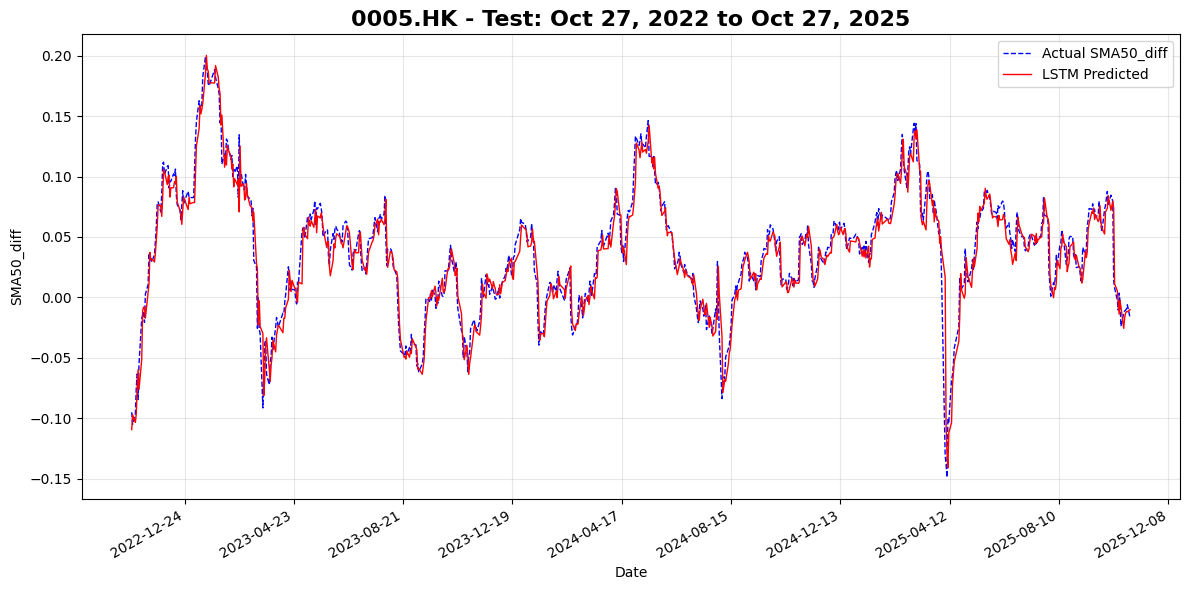


==================== TRAINING 0002.HK ====================


/home/bee/projects/finance/utils.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Epoch 50 | Validation Loss: 0.021343
Epoch 100 | Validation Loss: 0.018434
Epoch 150 | Validation Loss: 0.018688
Epoch 200 | Validation Loss: 0.017948
Best Epoch: 171, Validation RMSE: 0.017258, Test RMSE: 0.011826; 


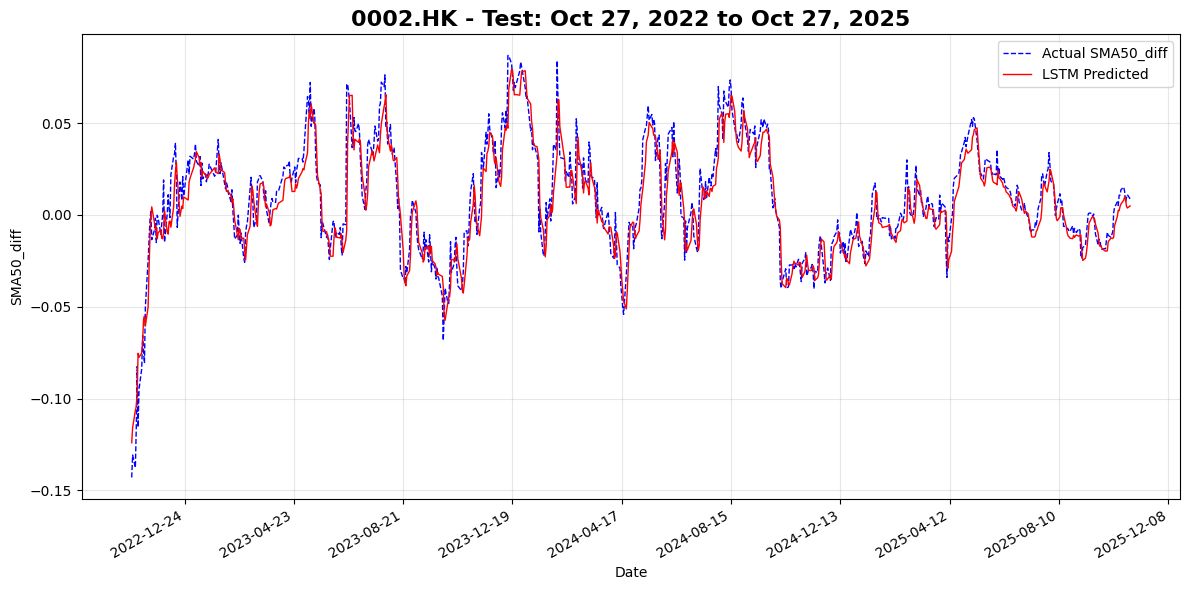


==================== TRAINING 0288.HK ====================


/home/bee/projects/finance/utils.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Epoch 50 | Validation Loss: 0.020586
Epoch 100 | Validation Loss: 0.018953
Epoch 150 | Validation Loss: 0.018691
Epoch 200 | Validation Loss: 0.018566
Best Epoch: 180, Validation RMSE: 0.018446, Test RMSE: 0.017425; 


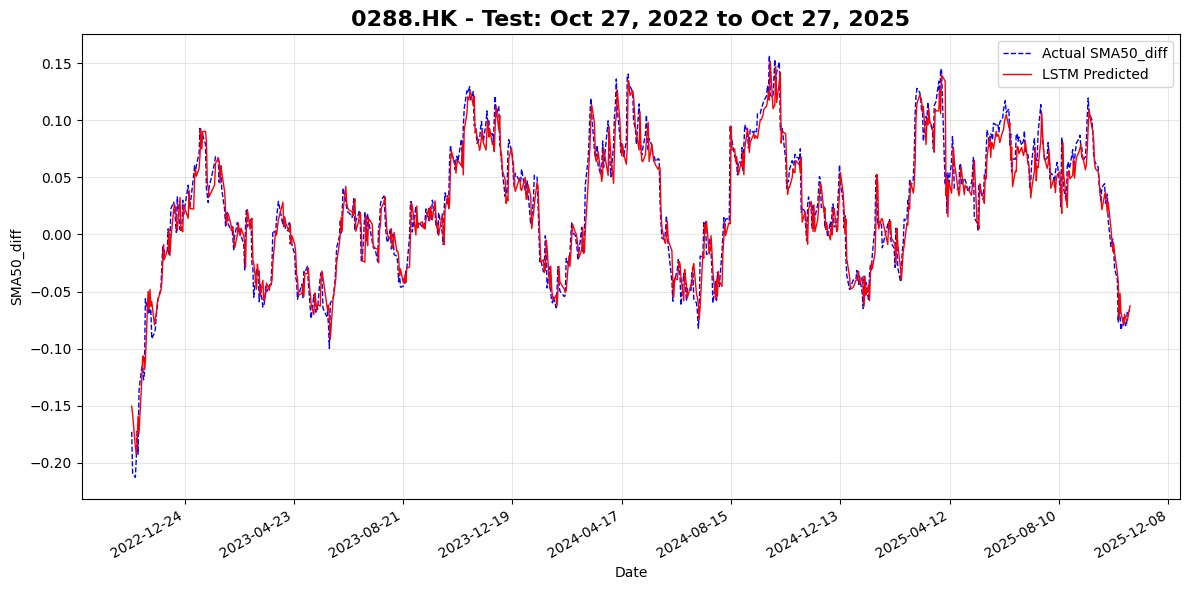


==================== TRAINING 2318.HK ====================


/home/bee/projects/finance/utils.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Epoch 50 | Validation Loss: 0.024048
Epoch 100 | Validation Loss: 0.022954
Epoch 150 | Validation Loss: 0.023213
Epoch 200 | Validation Loss: 0.022875
Best Epoch: 153, Validation RMSE: 0.022840, Test RMSE: 0.030430; 


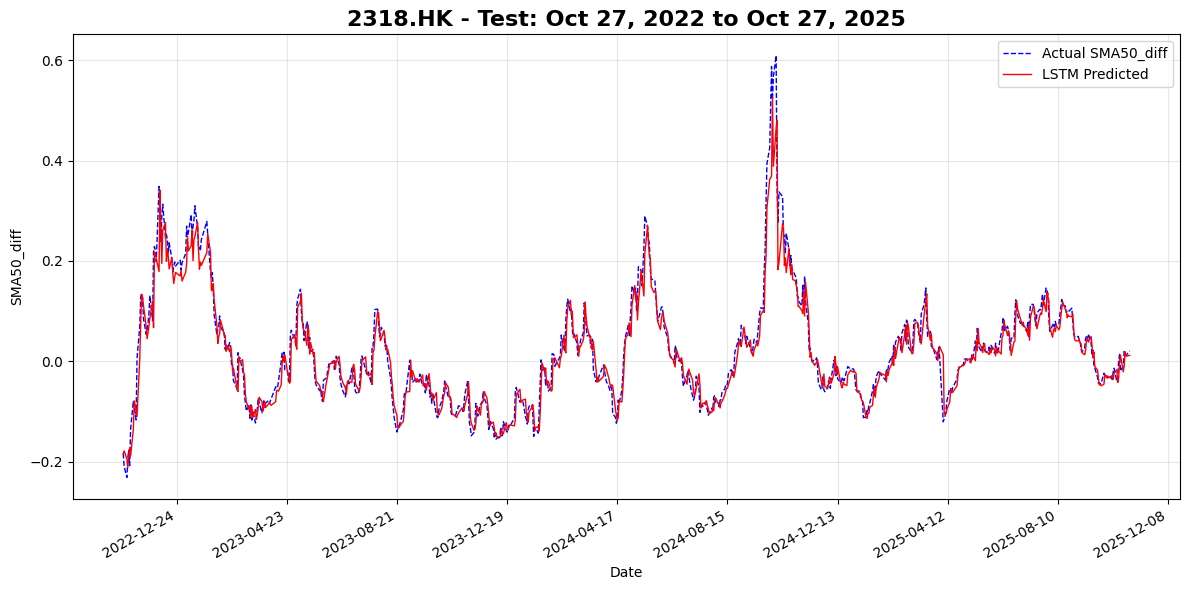


==================== TRAINING 3690.HK ====================


/home/bee/projects/finance/utils.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Epoch 50 | Validation Loss: 0.044888
Epoch 100 | Validation Loss: 0.040231
Epoch 150 | Validation Loss: 0.039962
Epoch 200 | Validation Loss: 0.039730
Best Epoch: 200, Validation RMSE: 0.039730, Test RMSE: 0.034121; 


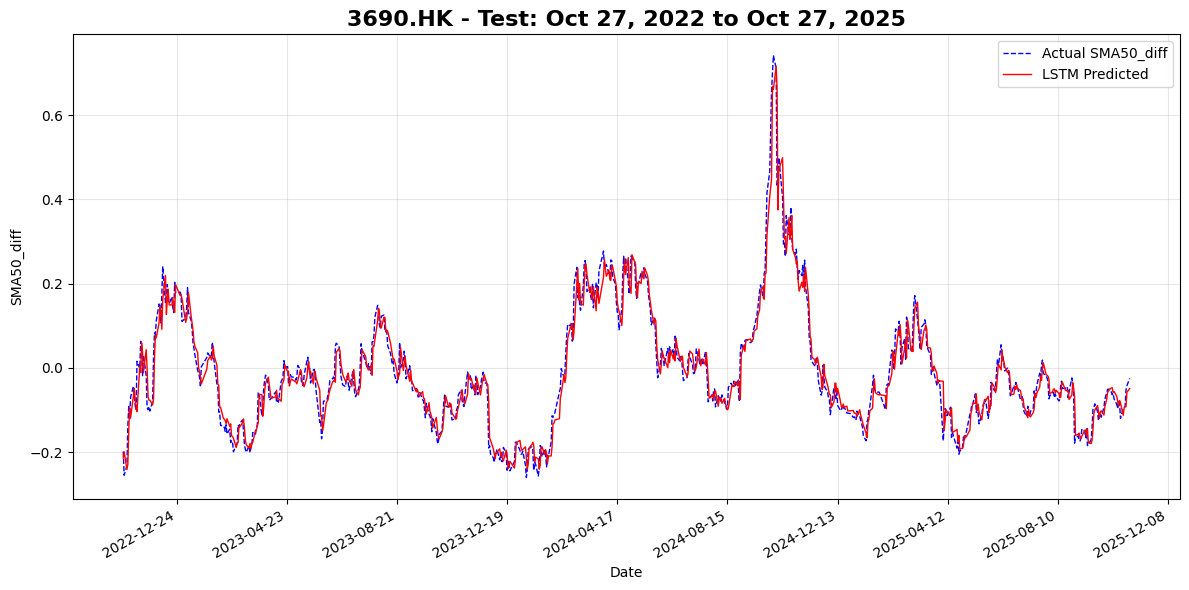

In [2]:
results = {}
for t in tickers:
    rmse = train(t)
    if rmse:
        results[t] = rmse

In [3]:
# =========INFERENCE============
import numpy as np
import torch
from datetime import datetime, timedelta
from utils import fetch_and_add_indicators
from model import LSTMModel

ticker = '0005.HK'
target_col = 'SMA50_diff'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len     = 60
epochs      = 200
batch_size  = 64
lr          = 1e-3
hidden_size = 128
lr_decay_step_size = 50
seed        = 55
features    = ['SMA50_diff','SMA20_diff','SMA10_diff','SMA100_diff']
target_col  = 'SMA50_diff'

test_start   = '2022-10-27'
test_end     = '2022-10-28'


buffer_start = (datetime.strptime(test_start, '%Y-%m-%d') - timedelta(days=300)).strftime('%Y-%m-%d')
df_full = fetch_and_add_indicators(ticker, features ,buffer_start, test_end)

df_test = df_full[test_start:test_end]

checkpoint = torch.load(f"models/{ticker}_lstm_{target_col}.pth", map_location=device,weights_only=False)

scaler = checkpoint['scaler']

model = LSTMModel()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
preds = []
with torch.no_grad():
    start_pos = df_full.index.get_loc(test_start) - seq_len
    for i in range(len(df_test)):
        window = scaler.transform(df_full)[start_pos + i : start_pos + i + seq_len]            
        inp = torch.tensor(window).unsqueeze(0).to(device)
        pred = model(inp).item()
        preds.append(pred)

# Inverse transform
dummy = np.zeros((len(preds), len(features)))
dummy[:, 0] = preds
preds_inv = scaler.inverse_transform(dummy)[:, 0]

df_test['next_day_SMA50_diff'] = preds_inv
df_test



/home/bee/projects/finance/utils.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
/tmp/ipykernel_67193/3102470734.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['next_day_SMA50_diff'] = preds_inv


Price,SMA50_diff,SMA20_diff,SMA10_diff,SMA100_diff,next_day_SMA50_diff
Ticker,,,,,
Date,,,,,
2022-10-27,-0.09497,-0.004342,-0.011896,-0.140232,-0.109356
